# Combined Cycle Power Plant Model - Assignment

This is an assignment for the Machine Learning for Product Managers from Duke University (on coursera). 

We will build a model to predict the electrical energy output of a Combined Cycle Power Plant, which uses a combination of gas turbines, steam turbines, and heat recovery steam generators to generate power.  We have a set of 9568 hourly average ambient environmental readings from sensors at the power plant which we will use in our model.

The columns in the data consist of hourly average ambient variables:

- Temperature (T) in the range 1.81°C to 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
- Net hourly electrical energy output (PE) 420.26-495.76 MW (Target we are trying to predict)

The dataset may be downloaded as a csv file here: https://archive.ics.uci.edu/ml/datasets/combined%2Bcycle%2Bpower%2Bplant

The goal is to select an appropriate model for modelling this prediction. We will try out various models such as Linear Regression, Liner Regression with Kfold validation, Ridge Regression, Lasso Regression and Polynomial Regression models. Based on the model that has the lowest MSE, we will select that model. 


### Let's import libraries/modules that we need

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


### Read the data file

In [2]:
full_df = pd.read_csv("CCPP_data.csv")

### Let's look at the top few rows and the column headers

In [3]:
full_df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### Rename colums so that we can better read them

In [4]:
full_df.rename(columns={'AT': 'Average Temperature', 'V': 'Exhaust Vacuum','AP': 'Ambient Pressure',
                  'RH': 'Relative Humidity', 'PE': 'Net Hourly Energy Electrical Output'}, inplace = True)

In [5]:
full_df.head()

,Average Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Energy Electrical Output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### Run some basic stats on the data and perform some Exploratory Data Analysis (EDA)

#### Look to see if there are any missing values

In [6]:
full_df.isnull().values.any()

False

In [7]:
full_df.isnull().sum()

Average Temperature                    0
Exhaust Vacuum                         0
Ambient Pressure                       0
Relative Humidity                      0
Net Hourly Energy Electrical Output    0
dtype: int64

In [8]:
full_df.describe()

,Average Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Energy Electrical Output
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Average Temperature                  9568 non-null   float64
 1   Exhaust Vacuum                       9568 non-null   float64
 2   Ambient Pressure                     9568 non-null   float64
 3   Relative Humidity                    9568 non-null   float64
 4   Net Hourly Energy Electrical Output  9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


#### Let's look at the correlation matrix

In [10]:
full_df.corr()["Net Hourly Energy Electrical Output"].sort_values(ascending=False)

Net Hourly Energy Electrical Output    1.000000
Ambient Pressure                       0.518429
Relative Humidity                      0.389794
Exhaust Vacuum                        -0.869780
Average Temperature                   -0.948128
Name: Net Hourly Energy Electrical Output, dtype: float64

##### Above we see that there is a strong positive corelation between Net Hourly Energy Electrical Output with Ambient Pressure. We also see that there is an even stronger positive correlation between Net Hourly Energy Electrical Output with Exhaust Vaccum and Average Temperature

### Now, we'll plot a histogram of the Net Hourly Energy Electrical Output 

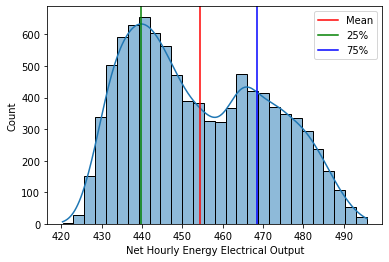

In [11]:
sns.histplot(data=full_df, x="Net Hourly Energy Electrical Output", kde=True)
plt.axvline(x=full_df["Net Hourly Energy Electrical Output"].mean(), c = 'red', label = 'Mean')
plt.axvline(x=np.percentile(full_df["Net Hourly Energy Electrical Output"], 25), c= 'green', label = '25%')
plt.axvline(x=np.percentile(full_df['Net Hourly Energy Electrical Output'], 75), c = 'blue', label = '75%')
plt.legend()



### Let's pair plot to visualize the correlations between the features


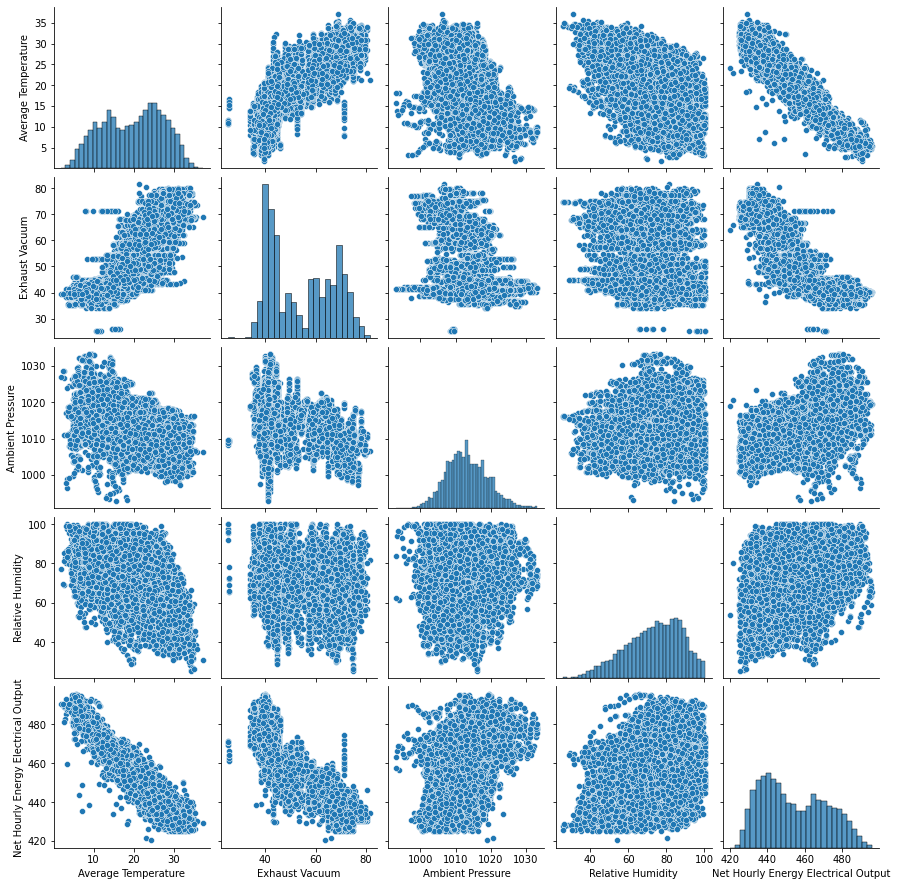

In [12]:
sns.pairplot(data = full_df)

### Build a Simple Linear Regression Model and examine MSE 

In [13]:
full_feature_dataset = full_df.drop("Net Hourly Energy Electrical Output", axis = 1).values
full_label_dataset = full_df["Net Hourly Energy Electrical Output"].values

train_features, test_features, train_labels, test_labels = train_test_split(full_feature_dataset, full_label_dataset, 
                                                    test_size=0.1, 
                                                    random_state=0)


In [14]:
lin_model = LinearRegression()

In [15]:
lin_model.fit(train_features, train_labels)

LinearRegression()

In [16]:
lin_model.score(test_features, test_labels)

0.9365341601931816

In [17]:
mean_absolute_error(train_labels, lin_model.predict(train_features))

3.634257522333831

In [18]:
mse_linear_model = mean_squared_error(train_labels, lin_model.predict(train_features))
print ("MSE Linear", mse_linear_model)

MSE Linear 20.922380033089247


In [19]:
lin_model.predict(test_features)

array([431.47530915, 458.55620422, 462.74382942, 448.60132846,
       457.88121879, 429.71532437, 473.05138414, 456.50287382,
       474.33946253, 446.31817648, 441.95521058, 441.50129283,
       444.70878689, 440.8617238 , 438.45854486, 454.28281181,
       444.89830329, 437.39167132, 451.33057445, 427.4513763 ,
       425.41255419, 431.84421994, 474.12547777, 439.79248433,
       447.90634715, 452.49225989, 481.67246311, 444.62061537,
       451.90744163, 466.60166352, 477.13802186, 461.89415454,
       473.90355353, 468.47795614, 469.5773357 , 433.75334443,
       466.38485711, 479.91974692, 433.80459   , 472.0683349 ,
       446.19057519, 466.38674205, 456.93135066, 479.73239051,
       443.63766648, 439.87754083, 433.1718293 , 438.24279747,
       470.21980845, 440.22491468, 457.86885182, 463.68598995,
       440.77508178, 467.50576542, 463.43226094, 443.30145264,
       483.71719752, 481.77734637, 459.98908555, 486.0212349 ,
       439.04012805, 449.26592903, 467.68226202, 448.02

In [20]:
lin_model.coef_

array([-1.9788836 , -0.23270791,  0.06291364, -0.15789   ])

In [21]:
lin_model.intercept_

453.7200601687169

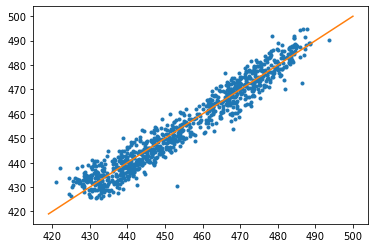

In [22]:
test_predictions = lin_model.predict(test_features)
plt.plot(test_predictions, test_labels, '.')
# plt.show()

# plot a line, a perfit predict would all fall on this line
x = np.linspace(419, 500, 10)
y = x
plt.plot(x, y)
plt.show()

### Build a Simple Linear Regression Model with KFold Validation and examine MSE 

In [23]:
#Using k fold validation

kfold = model_selection.KFold(n_splits=10, random_state=None)
model_lin_kfold = LinearRegression()
results_kfold = model_selection.cross_val_score(model_lin_kfold, train_features, train_labels, cv=kfold)

lin_kfold_cve = cross_validate(model_lin_kfold, train_features, train_labels,
                         scoring = 'neg_mean_squared_error',
                         cv = kfold,
                         return_train_score = True)
mse_lin_kfold = np.mean(np.absolute(lin_kfold_cve['test_score']))

print("MSE Linear Kfold: ", mse_lin_kfold)


MSE Linear Kfold:  20.947745731049185


### Build a Ridge Regression Model and examine MSE 

In [24]:
model_lin_ridge = Ridge(alpha = 1.0)
model_lin_ridge.fit(train_features, train_labels)
model_lin_ridge.score(test_features, test_labels)
mse_lin_ridge = mean_squared_error(train_labels, model_lin_ridge.predict(train_features))

print ("MSE Linear Rigde: ", mse_lin_ridge)

MSE Linear Rigde:  20.922380038356987


In [25]:
mean_absolute_error(train_labels, model_lin_ridge.predict(train_features))

3.634259931133578

### Build a Ridge Regression Model with Kfold Validation and examine MSE 

In [26]:
kfold_ridge = model_selection.KFold(n_splits=10, random_state=None)
model_lin_ridge_kfold = Ridge(alpha = 1.0)
results_ridge_kfold = model_selection.cross_val_score(model_lin_ridge_kfold, 
                                                      train_features, train_labels, 
                                                      cv = kfold)

#results_ridge_kfold1 = cross_validate(model_lin_ridge_kfold, train_features, train_labels, cv=5, return_estimator=True)
# print("Accuracy: %.2f%%" % (results_ridge_kfold.mean()*100))
# for model in results_ridge_kfold1['estimator']:
#    print (model.coef_, model.score )
# print(results_ridge_kfold1.keys())
# results_ridge_kfold1['test_score']

lin_ridge_kfold_cve = cross_validate(model_lin_ridge_kfold, train_features, train_labels,
                         scoring = 'neg_mean_squared_error',
                         cv = kfold,
                         return_train_score = True)
mse_lin_ridge_kfold = np.mean(np.absolute(lin_kfold_cve['test_score']))

print ("MSE Linear Ridge Kfold: ", mse_lin_ridge_kfold)

MSE Linear Ridge Kfold:  20.947745731049185


### Build a Lasso Regression Model with Kfold Validation and examine MSE 

In [27]:
kfold_ridge = model_selection.KFold(n_splits=10, random_state=None)
model_lin_lasso_kfold = Lasso(alpha = 0.1)

# results_lasso_kfold = model_selection.cross_val_score(model_lin_lasso_kfold, train_features, train_labels, cv = kfold)
# results_lasso_kfold1 = cross_validate(model_lin_lasso_kfold, train_features, train_labels, cv=5, return_estimator=True)
# print("Accuracy: %.2f%%" % (results_lasso_kfold.mean()*100))
# for model in results_lasso_kfold1['estimator']:
#      print (model.coef_)
# print(results_lasso_kfold1.keys())
# results_lasso_kfold1['test_score']

lin_lasso_kfold_cve = cross_validate(model_lin_lasso_kfold, train_features, train_labels,
                         scoring = 'neg_mean_squared_error',
                         cv = kfold,
                         return_train_score = True)
mse_lin_lasso_kfold = np.mean(np.absolute(lin_lasso_kfold_cve['test_score']))

print("MSE Linear Lasso Kfold: ", mse_lin_lasso_kfold)

MSE Linear Lasso Kfold:  20.948365040533997


### Build a Polynomial Regression Model for degree 8 and examine MSE 

In [28]:
Input=[('polynomial',PolynomialFeatures(degree=8)),('modal',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(train_features,train_labels)


Pipeline(steps=[('polynomial', PolynomialFeatures(degree=8)),
                ('modal', LinearRegression())])

In [29]:
poly_pred=pipe.predict(test_features)

In [30]:
pipe.score(test_features, test_labels)


0.9529618146177116

In [31]:
mse_poly_without_kfold = mean_squared_error(test_labels, poly_pred )
print ("MSE Polynomial Regression: ", mse_poly_without_kfold)

MSE Polynomial Regression:  14.359172267195234


### Build a Polynomial Regression Model for degrees upto 9 with Kfold validation and examine MSE

MSE Poly Degree 1  Kfold:  20.952904727366455
MSE Poly Degree 2  Kfold:  18.342407286720153
MSE Poly Degree 3  Kfold:  17.52718355591221
MSE Poly Degree 4  Kfold:  17.42360351777397
MSE Poly Degree 5  Kfold:  17.64229301489655
MSE Poly Degree 6  Kfold:  17.19258073883136
MSE Poly Degree 7  Kfold:  16.775484360338126
MSE Poly Degree 8  Kfold:  16.6466776737689
MSE Poly Degree 9  Kfold:  16.83764907616282


Text(0.5, 1.0, 'Mean Squared Error vs. Polynomial Degree')

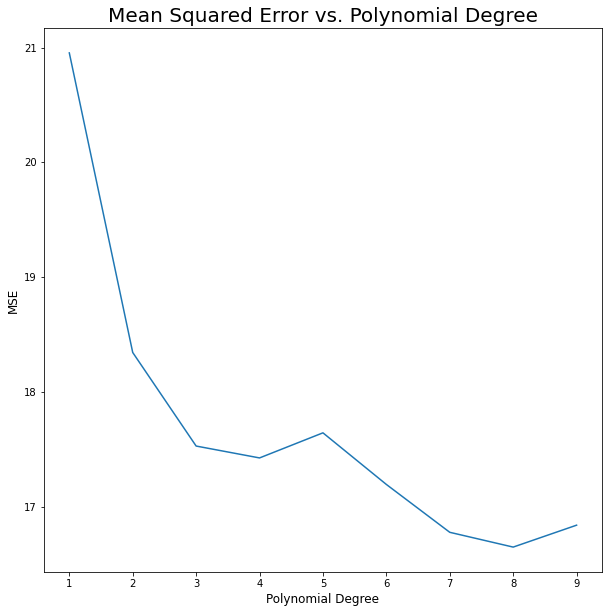

In [32]:
poly_degree = 10

training_error = []
cross_validation_error_poly = []

for d in range(1,poly_degree):
    x_poly_train = PolynomialFeatures(degree = d).fit_transform(train_features)
    x_poly_test = PolynomialFeatures(degree = d).fit_transform(test_features)
    
    lin_poly_model = LinearRegression(fit_intercept=False)
    model = lin_poly_model.fit(x_poly_train,train_labels)
    
    y_train_pred = lin_poly_model.predict(x_poly_train)
    
    # mse_train = mean_squared_error(train_labels,y_train_pred)
    #training_error.append(mse_train)
    
    cve = cross_validate(lin_poly_model, x_poly_train, train_labels,
                         scoring = 'neg_mean_squared_error',
                         cv = 5,
                         return_train_score = True)
    print("MSE Poly Degree", d, " Kfold: ",np.mean(np.absolute(cve['test_score'])))   
    cross_validation_error_poly.append(np.mean(np.absolute(cve['test_score'])))

cvep = np.array(cross_validation_error_poly)
 
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(range(1,poly_degree),cross_validation_error_poly)
ax.set_xlabel('Polynomial Degree',fontsize = 12)
ax.set_ylabel('MSE',fontsize = 12)
ax.set_title('Mean Squared Error vs. Polynomial Degree',fontsize = 20)



### Print all the MSE that we've calculated for various models 

In [33]:
print("MSE Poly Lin kfold for degrees 1-9: ", cross_validation_error_poly )

MSE Poly Lin kfold for degrees 1-9:  [20.952904727366455, 18.342407286720153, 17.52718355591221, 17.42360351777397, 17.64229301489655, 17.19258073883136, 16.775484360338126, 16.6466776737689, 16.83764907616282]


In [34]:
print("MSE Polynomial Regression Degree 8 : ", mse_poly_without_kfold)

MSE Polynomial Regression Degree 8 :  14.359172267195234


In [35]:
print("MSE Linear Lasso Kfold: ", mse_lin_lasso_kfold)

MSE Linear Lasso Kfold:  20.948365040533997


In [36]:
print ("MSE Linear Ridge Kfold: ", mse_lin_ridge_kfold)

MSE Linear Ridge Kfold:  20.947745731049185


In [37]:
print ("MSE Linear Rigde: ", mse_lin_ridge)

MSE Linear Rigde:  20.922380038356987


In [38]:
print("MSE Linear Kfold: ", mse_lin_kfold)

MSE Linear Kfold:  20.947745731049185


In [39]:
print ("MSE Linear", mse_linear_model)

MSE Linear 20.922380033089247


### We can see above that, the worst performing models are all the linear models 
### Poloynomial Regression (without kfold validation) @ the 8th degree has the lowest MSE = 14.3591722
### We will select that as our prediction model

## Thank you for reading this notebook. Feedback and input is welcome :)